In [1]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [130]:
idx = pd.IndexSlice

In [2]:
from backtesting import perform_backtest, PortfolioBacktest
from sharpe import calc_sharpe

In [26]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 1000

In [6]:
source_folder = 'files'

# Constants

In [5]:
capital = 1e6
lower_freq = 5

# Reading data

## 10Y US Notes

In [7]:
ust = pd.read_csv(f'{source_folder}/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [8]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

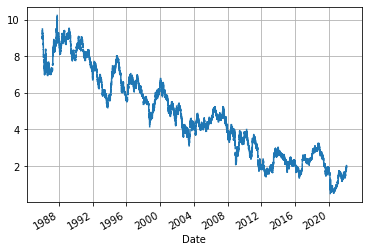

In [9]:
ust['Close'].plot()

plt.grid()
plt.show()

## Meta data

In [13]:
md = pd.read_csv(f'{source_folder}/meta_data.csv')

md = md[md.columns[1:]].copy()

In [99]:
md['sicsector'].value_counts()

Manufacturing                                                      122
Finance Insurance And Real Estate                                   71
Services                                                            37
Transportation Communications Electric Gas And Sanitary Service     30
Retail Trade                                                        15
Wholesale Trade                                                     11
Mining                                                              11
Construction                                                         3
Name: sicsector, dtype: int64

In [100]:
md['table'].value_counts()

SF1    300
Name: table, dtype: int64

In [27]:
md

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,sicindustry,famasector,famaindustry,sector,industry,scalemarketcap,scalerevenue,relatedtickers,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
0,SF1,195812,ABC,Amerisourcebergen Corp,NYSE,N,Domestic,03073E105 03071P102,5122.0,Wholesale Trade,Wholesale-Drugs Proprietaries & Druggists' Sun...,NaN,Wholesale,Healthcare,Medical Distribution,5 - Large,5 - Large,AAS ASHC,USD,Pennsylvania; U.S.A,2020-05-07,2014-11-01,1995-04-04,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.amerisourcebergen.com
1,SF1,199843,ABCP,Ambase Corp,OTC,N,Domestic,023164106,6512.0,Finance Insurance And Real Estate,Operators Of Nonresidential Buildings,NaN,Real Estate,Real Estate,REIT - Diversified,2 - Micro,1 - Nano,NaN,USD,Connecticut; U.S.A,2020-05-08,2016-02-17,1986-01-01,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,NaN
2,SF1,198315,ABMD,Abiomed Inc,NASDAQ,N,Domestic,003654100,3841.0,Manufacturing,Surgical & Medical Instruments & Apparatus,NaN,Medical Equipment,Healthcare,Medical Devices,5 - Large,3 - Small,NaN,USD,Massachusetts; U.S.A,2020-05-21,2014-10-14,1987-07-30,2020-05-27,1997-03-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.abiomed.com
3,SF1,196870,ACY,Aerocentury Corp,NYSEMKT,N,Domestic,007737109,7359.0,Services,Services-Equipment Rental & Leasing Nec,NaN,Business Services,Industrials,Rental & Leasing Services,1 - Nano,1 - Nano,NaN,USD,California; U.S.A,2020-03-31,2014-12-22,1998-01-20,2020-05-27,1996-12-31,2019-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aerocentury.com
4,SF1,199972,AEP,American Electric Power Co Inc,NYSE,N,Domestic Primary,025537101,4911.0,Transportation Communications Electric Gas And...,Electric Services,NaN,Utilities,Utilities,Utilities - Regulated Electric,5 - Large,5 - Large,AEP-PB,USD,Ohio; U.S.A,2020-05-06,2014-12-17,1986-01-01,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aep.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,SF1,199203,WWD,Woodward Inc,NASDAQ,N,Domestic,980745103,3620.0,Manufacturing,Electrical Industrial Apparatus,NaN,Electrical Equipment,Industrials,Aerospace & Defense,4 - Mid,4 - Mid,NaN,USD,Colorado; U.S.A,2020-05-12,2014-09-30,1996-05-30,2020-05-27,1997-09-30,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.woodward.com
296,SF1,196891,WYY,Widepoint Corp,NYSEMKT,N,Domestic,967590100,7373.0,Services,Services-Computer Integrated Systems Design,NaN,Computers,Technology,Information Technology Services,2 - Micro,2 - Micro,WDPT,USD,Virginia; U.S.A,2020-05-14,2015-12-11,1998-05-19,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.widepoint.com
297,SF1,198693,XLNX,Xilinx Inc,NASDAQ,N,Domestic,983919101,3674.0,Manufacturing,Semiconductors & Related Devices,NaN,Electronic Equipment,Technology,Semiconductors,5 - Large,4 - Mid,NaN,USD,California; U.S.A,2020-05-08,2014-09-25,1990-06-18,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.xilinx.com
298,SF1,198868,YRCW,YRC Worldwide Inc,NASDAQ,N,Domestic,984249607 984249102 984249300 985509108 985577105,4213.0,Transportation Communications Electric Gas And...,Trucking (No Local),NaN,Transportation,Industrials,Trucking,4 - Mid,4 - Mid,NaN,USD,Kansas; U.S.A,2020-05-12,2015-11-23,1986-07-09,2020-05-27,1996-12-31,2020-03-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.yrcw.com


## Indicators descrition

In [30]:
desc = pd.read_csv(f'{source_folder}/indicators_description.csv')

desc.replace('Y', True, inplace=True)
desc.replace('N', False, inplace=True)

In [119]:
desc['table'].value_counts()

SF1           111
EVENTCODES     37
SF3A           29
SF3B           28
TICKERS        28
SF2            24
SFP            10
DAILY          10
SEP            10
SF3             7
ACTIONS         7
INDICATORS      7
SP500           7
EVENTS          3
Name: table, dtype: int64

In [127]:
_cols = ['table', 'indicator']
if not desc[_cols].duplicated().any():
    desc.set_index(_cols, inplace=True)
else:
    raise Excpetion('There are duplicates')

In [128]:
desc[desc['isprimarykey']]

isfilter  isprimarykey  \
table      indicator                              
SF1        ticker            True          True   
           dimension         True          True   
           datekey          False          True   
           reportperiod     False          True   
SF2        ticker            True          True   
           filingdate        True          True   
           formtype         False          True   
           ownername         True          True   
           rownum           False          True   
SF3        ticker            True          True   
           investorname      True          True   
           securitytype      True          True   
           calendardate      True          True   
SF3A       calendardate      True          True   
           ticker            True          True   
SFP        ticker            True          True   
           date              True          True   
ACTIONS    date              True          True   
           action            True          True   
           ticker            True          True   
           contraticker      True          True   
DAILY      ticker            True          True   
           date              True          True   
EVENTS     date              True          True   
           ticker            True          True   
INDICATORS table             True          True   
           indicator         True          True   
           isfilter          True          True   
           isprimarykey      True          True   
SEP        ticker            True          True   
           date              True          True   
SP500      date              True          True   
           action            True          True   
           ticker            True          True   
TICKERS    table             True          True   
           permaticker       True          True   
           ticker            True          True   

                                                   title  \
table      indicator                                       
SF1        ticker                          Ticker Symbol   
           dimension                           Dimension   
           datekey                              Date Key   
           reportperiod                    Report Period   
SF2        ticker                          Ticker Symbol   
           filingdate                        Filing Date   
           formtype                            Form Type   
           ownername     Owner Name (Insider / Investor)   
           rownum                             Row Number   
SF3        ticker                          Ticker Symbol   
           investorname      Institutional Investor Name   
           securitytype                    Security Type   
           calendardate                    Calendar Date   
SF3A       calendardate                    Calendar Date   
           ticker                          Ticker Symbol   
SFP        ticker                          Ticker Symbol   
           date                               Price Date   
ACTIONS    date                                     Date   
           action                                 Action   
           ticker                          Ticker Symbol   
           contraticker             Contra Ticker Symbol   
DAILY      ticker                          Ticker Symbol   
           date                               Price Date   
EVENTS     date                              Filing Date   
           ticker                          Ticker Symbol   
INDICATORS table                          Sharadar Table   
           indicator                      Indicator Code   
           isfilter                           Is Filter?   
           isprimarykey                  Is Primary Key?   
SEP        ticker                          Ticker Symbol   
           date                               Price Date   
SP500      date                                     Dat

In [129]:
desc.xs('table', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
INDICATORS,True,True,Sharadar Table,"The database table which the ticker is featured in. Examples are: ""SF1"" or ""SEP"".\t",text
TICKERS,True,True,Sharadar Table,"The database table which the ticker is featured in. Examples are: ""SF1"" or ""SEP.",text


In [134]:
desc.xs('dimension', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,True,True,Dimension,[Entity] The dimension field allows you to take different dimensional views of data over time. ARQ: Quarterly; excluding restatements; MRQ: Quarterly; including restatements; ARY: annual; excluding restatements; MRY: annual; including restatements; ART: trailing-twelve-months; excluding restatements; MRT: trailing-twelve-months; including restatements.,text


In [146]:
desc.xs('datekey', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,False,True,Date Key,[Entity] The Date Key represents the SEC filing date for AR dimensions (ARQ;ART;ARY); and the [REPORTPERIOD] for MR dimensions (MRQ;MRT;MRY). In addition; this is the observation date used for [Price] based data such as [MarketCap]; [Price] and [PE].,date (YYYY-MM-DD)


In [147]:
desc.xs('calendardate', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,True,False,Calendar Date,"[Entity] The Calendar Date represents the normalized [ReportPeriod]. This provides a common date to query for which is necessary due to irregularity in report periods across companies. For example; if the report period is ""2015-09-26""; the calendar date will be ""2015-09-30"" for quarterly and trailing-twelve-month dimensions (ARQ;MRQ;ART;MRT); and ""2015-12-31"" for annual dimensions (ARY;MRY). We also employ offsets in order to maximise comparability of the period across companies. For example consider two companies: one with a quarter ending on 2018-07-24; and the other with a quarter ending on 2018-06-28. A naive normalization process would assign these to differing calendar quarters of 2018-09-30 and 2018-06-30 respectively. However, we assign these both to the 2018-06-30 calendar quarter because this maximises the overlap in the report periods in question and therefore the comparability of this period.",date (YYYY-MM-DD)
SF3,True,True,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)
SF3A,True,True,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)
SF3B,True,False,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)


In [177]:
desc.xs('reportperiod', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,False,True,Report Period,[Entity] The Report Period represents the end date of the fiscal period.,date (YYYY-MM-DD)


In [165]:
desc[desc.index.get_level_values('indicator').str.contains('asset')]

isfilter  isprimarykey               title  \
table indicator                                                   
SF1   assets            False         False        Total Assets   
      taxassets         False         False          Tax Assets   
      assetsc           False         False      Current Assets   
      assetsnc          False         False  Assets Non-Current   
      assetsavg         False         False      Average Assets   
      assetturnover     False         False      Asset Turnover   

                                                                                                                                                                                                                           description  \
table indicator                                                                                                                                                                                                                          
SF1   assets         [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables].   
      taxassets                                                                                                                                       [Balance Sheet] A component of [Assets] representing tax assets and receivables.   
      assetsc                                                                 [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets.   
      assetsnc                            [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total Assets [Assets] and Current Assets [AssetsC].   
      assetsavg                                                                                                            [Metrics] Average asset value for the period used in calculation of [ROE] and [ROA]; derived from [Assets].   
      assetturnover                                                  [Metrics] Asset turnover is a measure of a firms operating efficiency; calculated by dividing [Revenue] by [AssetsAVG]. Often a component of DuPont ROE analysis.   

                     unittype  
table indicator                
SF1   assets         currency  
      taxassets      currency  
      assetsc        currency  
      assetsnc       currency  
      assetsavg      currency  
      assetturnover         %

## Fundamental data

In [273]:
fd = pd.read_csv(f'{source_folder}/fundamental_data.csv')

fd = fd[fd.columns[1:]].copy()

fd.sort_index(ascending=True, inplace=True)

_cols = ['datekey', 'calendardate', 'reportperiod', 'lastupdated']
for _col in _cols:
    fd[_col] = pd.to_datetime(fd[_col])

In [274]:
_cols = ['ticker', 'dimension', 'datekey']
if not fd[_cols].duplicated().any():
    fd.set_index(_cols, inplace=True)
else:
    raise Exception('There are duplicates')

In [275]:
fd.index.get_level_values('dimension').value_counts()

MRT    28051
MRQ    27648
ART    26977
ARQ    26851
MRY     7393
ARY     6982
Name: dimension, dtype: int64

### AR dimension only

In [278]:
fd_ar = fd[fd.index.get_level_values('dimension').str.contains('^AR.', regex=True)].copy()

In [284]:
fd_ar.xs('ABC').xs('ARQ').resample('D', axis='index')

In [289]:
fd_ar.reset_index().set_index('datekey').groupby(['ticker', 'dimension']).resample('D', axis='index').bfill()

AssertionError: axis must be 0

## Quotes

In [64]:
path = f'{source_folder}/data'
files_paths = glob.glob(path + '/*')

In [66]:
len(files_paths)

299

In [95]:
_qts = {}
for file_path in files_paths:
    file_name = file_path.split('/')[-1].split('.')[0]
    
    _df = pd.read_csv(file_path).set_index('Date').copy()
    _qts[file_name] = _df

qts = pd.concat(_qts, keys=_qts.keys()).copy()
qts.index.names = ['Ticker', 'Date']

qts = qts['Close'].copy()

In [96]:
if qts.index.duplicated().any():
    raise Exception('There are duplicates in the index')

In [97]:
qts

Ticker  Date      
SBGI    1998-12-01     5.910925
        1998-12-02     6.276548
        1998-12-03     6.337485
        1998-12-04     6.611702
        1998-12-07     7.342947
                        ...    
ARGO    2020-05-26    31.887527
        2020-05-27    33.701313
        2020-05-28    33.573395
        2020-05-29    30.198345
        2020-06-01    31.113445
Name: Close, Length: 1617309, dtype: float64

# Setting some params

# Strategy

In [212]:
fd['assets'].isna().sum()

2281

In [214]:
fd['revenue'].isna().sum()

2429

In [215]:
help(pd.Series.fillna)

Help on function fillna in module pandas.core.series:

fillna(self, value: 'object | ArrayLike | None' = None, method: 'FillnaOptions | None' = None, axis=None, inplace=False, limit=None, downcast=None) -> 'Series | None'
    Fill NA/NaN values using the specified method.
    
    Parameters
    ----------
    value : scalar, dict, Series, or DataFrame
        Value to use to fill holes (e.g. 0), alternately a
        dict/Series/DataFrame of values specifying which value to use for
        each index (for a Series) or column (for a DataFrame).  Values not
        in the dict/Series/DataFrame will not be filled. This value cannot
        be a list.
    method : {'backfill', 'bfill', 'pad', 'ffill', None}, default None
        Method to use for filling holes in reindexed Series
        pad / ffill: propagate last valid observation forward to next valid
        backfill / bfill: use next valid observation to fill gap.
    axis : {0 or 'index'}
        Axis along which to fill missing val

In [218]:
fd.xs('ART', level='dimension')['revenue'].fillna(method='backfill')

ticker  datekey   
ABC     1998-02-05    8.668804e+09
        1998-05-12    8.668804e+09
        1998-08-12    8.668804e+09
        1998-12-23    8.668804e+09
        1999-02-12    8.583910e+09
                          ...     
ZEUS    2019-05-02    1.785402e+09
        2019-08-01    1.761636e+09
        2019-11-08    1.688890e+09
        2020-02-21    1.579040e+09
        2020-05-01    1.487501e+09
Name: revenue, Length: 26977, dtype: float64

In [239]:
fd.xs('ART', level='dimension')['assets'].groupby('ticker').fillna(method='backfill')

ticker  datekey   
ABC     1998-02-05    1.780096e+09
        1998-05-12    1.631171e+09
        1998-08-12    1.575976e+09
        1998-12-23    1.552282e+09
        1999-02-12    1.806918e+09
                          ...     
ZEUS    2019-05-02    7.993620e+08
        2019-08-01    7.244050e+08
        2019-11-08    6.987430e+08
        2020-02-21    6.495550e+08
        2020-05-01    6.779670e+08
Name: assets, Length: 26977, dtype: float64

In [240]:
ratio = fd.xs('ART', level='dimension')['revenue'].groupby('ticker').fillna(method='backfill') / \
    fd.xs('ART', level='dimension')['assets'].groupby('ticker').fillna(method='backfill')

In [242]:
ratio

ticker  datekey   
ABC     1998-02-05    4.869852
        1998-05-12    5.314467
        1998-08-12    5.500594
        1998-12-23    5.584555
        1999-02-12    4.750581
                        ...   
ZEUS    2019-05-02    2.233534
        2019-08-01    2.431839
        2019-11-08    2.417040
        2020-02-21    2.430957
        2020-05-01    2.194061
Length: 26977, dtype: float64

In [243]:
fd.xs('ART', level='dimension')['revenue'].groupby('ticker').\
    fillna(method='backfill').loc[idx[:, '1994-05-01':'1994:05-10']]

ticker  datekey   
BA      1994-05-13    2.192400e+10
        1994-08-09    2.192400e+10
        1994-11-07    2.192400e+10
CDE     1994-05-13    9.102259e+07
        1994-08-15    9.102259e+07
        1994-11-14    9.102259e+07
LMT     1994-05-09    1.313000e+10
        1994-08-05    1.313000e+10
        1994-11-09    1.313000e+10
MSFT    1994-05-03    4.649000e+09
        1994-09-27    4.649000e+09
        1994-11-14    4.913000e+09
        1994-11-16    4.913000e+09
Name: revenue, dtype: float64

In [222]:
ratio_n.groupby('datekey').sum()

datekey
1994-02-14    1.0
1994-03-07    1.0
1994-03-17    1.0
1994-05-03    1.0
1994-05-09    1.0
             ... 
2020-05-20    1.0
2020-05-21    1.0
2020-05-22    1.0
2020-05-26    1.0
2020-05-27    1.0
Length: 4429, dtype: float64

In [241]:
ratio.xs('1994-05-09', level='datekey')

ticker
LMT    1.458079
dtype: float64

In [227]:
ratio_n.xs('1994-05-09', level='datekey')

ticker
LMT    1.0
dtype: float64

In [225]:
logging.basicConfig(level=logging.WARNING)

In [170]:
class RatioStrategyBacktest(PortfolioBacktest):
    def run_strategy(self,
                     ratio: pd.Series):
        logger = logging.getLogger(f'{self.logger.name}.run_strategy')
        
        ratio = ratio.copy()
        
        ratio_n = ratio.groupby('datekey').apply(lambda _ser: _ser / _ser.sum())
        if not (ratio_n == 1).all():
            logger.warning('Normalized ratio sum != 1 for some dates')
        
        for i, date in enumerate(self.dates[:-1]):
            next_date = self.dates[i + 1]
            
            